In [1]:
# Imports

########################################################################
# Python Standard Libraries
import os

########################################################################
# Numpy Library
import numpy as np # linear algebra

########################################################################
# Pandas Library
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

########################################################################
# MATPLOT Library
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

########################################################################
# SKLearn Library
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Utility functions

########################################################################
# Walk through input files
def print_input_files():
    # Input data files are available in the "../input/" directory.
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

########################################################################
# Dump text files
def dump_text_file(fname):
    with open(fname, 'r') as f:
        print(f.read())

########################################################################
# Dump CSV files
def dump_csv_file(fname, count=5):
    # count: 0 - column names only, -1 - all rows, default = 5 rows max
    df = pd.read_csv(fname)
    if count < 0:
        count = df.shape[0]
    return df.head(count)

########################################################################
# Dataset related functions
ds_nbaiot = '/kaggle/input/nbaiot-dataset'
dn_nbaiot = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell', 'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera', 'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam', 'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']

def fname(ds, f):
    if '.csv' not in f:
        f = f'{f}.csv'
    return os.path.join(ds, f)

def fname_nbaiot(f):
    return fname(ds_nbaiot, f)

def get_nbaiot_device_files():
    nbaiot_all_files = dump_csv_file(fname_nbaiot('data_summary'), -1)
    nbaiot_all_files = nbaiot_all_files.iloc[:,0:1].values
    device_id = 1
    indices = []
    for j in range(len(nbaiot_all_files)):
        if str(device_id) not in str(nbaiot_all_files[j]):
            indices.append(j)
            device_id += 1
    nbaiot_device_files = np.split(nbaiot_all_files, indices)
    return nbaiot_device_files

def get_nbaiot_device_data(device_id):
    if device_id < 1 or device_id > 9:
        assert False, "Please provide a valid device ID 1-9, both inclusive"
    device_index = device_id -1
    device_files = get_nbaiot_device_files()
    device_file = device_files[device_index]
    df = pd.DataFrame()
    y = []
    for i in range(len(device_file)):
        fname = str(device_file[i][0])
        df_c = pd.read_csv(fname_nbaiot(fname))
        rows = df_c.shape[0]
        print("processing", fname, "rows =", rows)
        y_np = np.ones(rows) if 'benign' in fname else np.zeros(rows)
        y.extend(y_np.tolist())
        df = pd.concat([df.iloc[:,:].reset_index(drop=True),
                      df_c.iloc[:,:].reset_index(drop=True)], axis=0)
    X = df.iloc[:,:].values
    y = np.array(y)
    return (X, y)

def get_nbaiot_devices_data():
    devices_data = []
    for i in range(9):
        device_id = i + 1
        (X, y) = get_nbaiot_device_data(device_id)
        devices_data.append((X, y))
    return devices_data
#print_input_files()

def plot_scatter_nbaiot_device(device_data, device_id):
    if device_id < 1 or device_id > 9:
        assert False, "Please provide a valid device ID 1-9, both inclusive"
    device_index = device_id-1
    print("scatter plot for", dn_nbaiot[device_index])
    (X, y) = device_data
    X_std = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_std)
    data_X = X_pca[:,0]
    data_Y = X_pca[:,1]
    data_Z = y
    data = np.column_stack((data_X, data_Y, data_Z))
    plot_3d_scatter(data)

########################################################################
# Visualization related functions
def plot_3d_histogram(data):
    cols = data.shape[1]
    if cols < 2:
        assert False, 'The number of columns should be 2'
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X = data[:,0]
    Y = data[:,1]
    bins = 10
    hist, xedges, yedges = np.histogram2d(X, Y, bins=bins, range=[[0, bins*0.6], [0, bins*0.6]])

    # Construct arrays for the anchor positions of the bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = dy = 0.5 * np.ones_like(zpos)
    dz = hist.ravel()

    cmap = cm.get_cmap('cool')
    max_height = np.max(dz)
    min_height = np.min(dz)
    rgba = [cmap((k-min_height)/max_height) for k in dz] 
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=rgba)

    plt.show()

def plot_3d_surface(data, func):
    cols = data.shape[1]
    if cols < 2:
        assert False, 'The number of columns should be 2'
    X = data[:,0]
    Y = data[:,1]
    X, Y = np.meshgrid(X, Y)
    Z = func(X, Y)
    #print(Z.shape)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_title('surface');

def plot_3d_scatter(data, title=None, xlabel=None, ylabel=None, zlabel=None):
    cols = data.shape[1]
    if cols < 3:
        assert False, 'The number of columns should be 3'
    X = data[:,0]
    Y = data[:,1]
    Z = data[:,2]
    ax = plt.axes(projection='3d')
    ax.scatter(X, Y, Z, c = Z, cmap='RdYlGn')
    ax.set_title(title);
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    plt.show()

def plot_2d_scatter(data, title=None, xlabel=None, ylabel=None, handles=None):
    cols = data.shape[1]
    if cols < 3:
        assert False, 'The number of columns should be 3'
    X = data[:,0]
    Y = data[:,1]
    Z = data[:,2]
    ax = plt.axes()
    scatter = ax.scatter(X, Y, c = ['green' if z > 0.5 else 'red' for z in Z], cmap='RdYlGn')
    ax.set_title(title);
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend(handles=handles)
    plt.show()

In [3]:
def plot_scatter_nbaiot_devices(dim3=True):
    for i in range(9):
        device_id = i + 1
        device_index = i
        device_data = get_nbaiot_device_data(device_id)
        (X, y) = device_data
        X_std = StandardScaler().fit_transform(X)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_std)
        data_X = X_pca[:,0]
        data_Y = X_pca[:,1]
        data_Z = y
        data = np.column_stack((data_X, data_Y, data_Z))
        if dim3:
            plot_3d_scatter(data, dn_nbaiot[device_index], 'PCA1', 'PCA2', 'Normal or Anomalous')
        else:
            normal = mpatches.Patch(color='green', label='N')
            anomalous = mpatches.Patch(color='red', label='A')
            handles = [normal, anomalous]
            plot_2d_scatter(data, dn_nbaiot[device_index], 'PCA1', 'PCA2', handles)

processing 1.benign.csv rows = 49548
processing 1.gafgyt.combo.csv rows = 59718
processing 1.gafgyt.junk.csv rows = 29068
processing 1.gafgyt.scan.csv rows = 29849
processing 1.gafgyt.tcp.csv rows = 92141
processing 1.gafgyt.udp.csv rows = 105874
processing 1.mirai.ack.csv rows = 102195
processing 1.mirai.scan.csv rows = 107685
processing 1.mirai.syn.csv rows = 122573
processing 1.mirai.udp.csv rows = 237665
processing 1.mirai.udpplain.csv rows = 81982


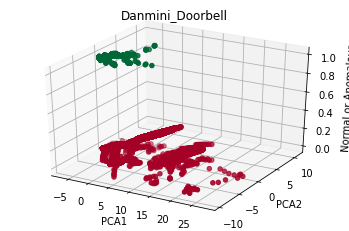

processing 2.benign.csv rows = 13113
processing 2.gafgyt.combo.csv rows = 53012
processing 2.gafgyt.junk.csv rows = 30312
processing 2.gafgyt.scan.csv rows = 27494
processing 2.gafgyt.tcp.csv rows = 95021
processing 2.gafgyt.udp.csv rows = 104791
processing 2.mirai.ack.csv rows = 113285
processing 2.mirai.scan.csv rows = 43192
processing 2.mirai.syn.csv rows = 116807
processing 2.mirai.udp.csv rows = 151481
processing 2.mirai.udpplain.csv rows = 87368


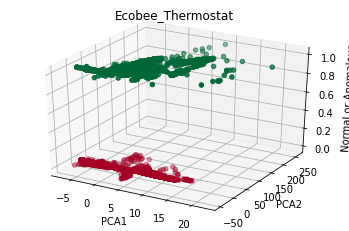

processing 3.benign.csv rows = 39100
processing 3.gafgyt.combo.csv rows = 53014
processing 3.gafgyt.junk.csv rows = 29797
processing 3.gafgyt.scan.csv rows = 28120
processing 3.gafgyt.tcp.csv rows = 101536
processing 3.gafgyt.udp.csv rows = 103933


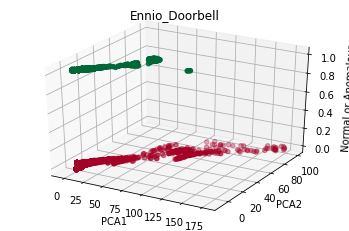

processing 4.benign.csv rows = 175240
processing 4.gafgyt.combo.csv rows = 58152
processing 4.gafgyt.junk.csv rows = 28349
processing 4.gafgyt.scan.csv rows = 27859
processing 4.gafgyt.tcp.csv rows = 92581
processing 4.gafgyt.udp.csv rows = 105782
processing 4.mirai.ack.csv rows = 91123
processing 4.mirai.scan.csv rows = 103621
processing 4.mirai.syn.csv rows = 118128
processing 4.mirai.udp.csv rows = 217034
processing 4.mirai.udpplain.csv rows = 80808


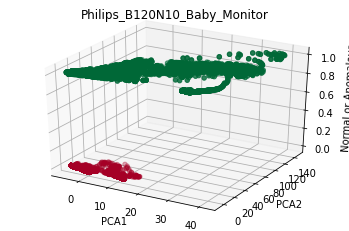

processing 5.benign.csv rows = 62154
processing 5.gafgyt.combo.csv rows = 61380
processing 5.gafgyt.junk.csv rows = 30898
processing 5.gafgyt.scan.csv rows = 29297
processing 5.gafgyt.tcp.csv rows = 104510
processing 5.gafgyt.udp.csv rows = 104011
processing 5.mirai.ack.csv rows = 60554
processing 5.mirai.scan.csv rows = 96781
processing 5.mirai.syn.csv rows = 65746
processing 5.mirai.udp.csv rows = 156248
processing 5.mirai.udpplain.csv rows = 56681


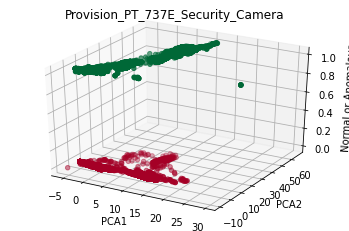

processing 6.benign.csv rows = 98514
processing 6.gafgyt.combo.csv rows = 57530
processing 6.gafgyt.junk.csv rows = 29068
processing 6.gafgyt.scan.csv rows = 28397
processing 6.gafgyt.tcp.csv rows = 89387
processing 6.gafgyt.udp.csv rows = 104658
processing 6.mirai.ack.csv rows = 57997
processing 6.mirai.scan.csv rows = 97096
processing 6.mirai.syn.csv rows = 61851
processing 6.mirai.udp.csv rows = 158608
processing 6.mirai.udpplain.csv rows = 53785


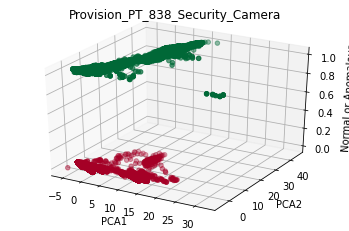

processing 7.benign.csv rows = 52150
processing 7.gafgyt.combo.csv rows = 58669
processing 7.gafgyt.junk.csv rows = 28305
processing 7.gafgyt.scan.csv rows = 27698
processing 7.gafgyt.tcp.csv rows = 97783
processing 7.gafgyt.udp.csv rows = 110617


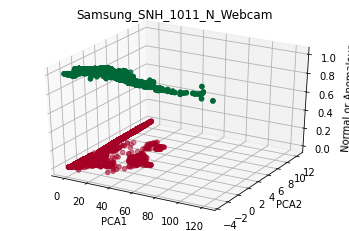

processing 8.benign.csv rows = 46585
processing 8.gafgyt.combo.csv rows = 54283
processing 8.gafgyt.junk.csv rows = 28579
processing 8.gafgyt.scan.csv rows = 27825
processing 8.gafgyt.tcp.csv rows = 88816
processing 8.gafgyt.udp.csv rows = 103720
processing 8.mirai.ack.csv rows = 111480
processing 8.mirai.scan.csv rows = 45930
processing 8.mirai.syn.csv rows = 125715
processing 8.mirai.udp.csv rows = 151879
processing 8.mirai.udpplain.csv rows = 78244


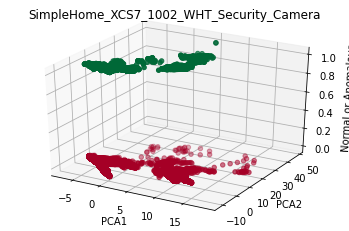

processing 9.benign.csv rows = 19528
processing 9.gafgyt.combo.csv rows = 59398
processing 9.gafgyt.junk.csv rows = 27413
processing 9.gafgyt.scan.csv rows = 28572
processing 9.gafgyt.tcp.csv rows = 98075
processing 9.gafgyt.udp.csv rows = 102980
processing 9.mirai.ack.csv rows = 107187
processing 9.mirai.scan.csv rows = 43674
processing 9.mirai.syn.csv rows = 122479
processing 9.mirai.udp.csv rows = 157084
processing 9.mirai.udpplain.csv rows = 84436


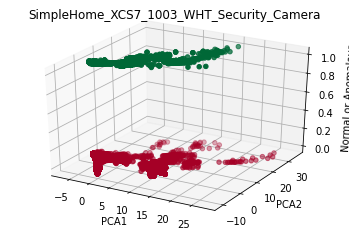

In [4]:
plot_scatter_nbaiot_devices() # 3D Scatter Plots

processing 1.benign.csv rows = 49548
processing 1.gafgyt.combo.csv rows = 59718
processing 1.gafgyt.junk.csv rows = 29068
processing 1.gafgyt.scan.csv rows = 29849
processing 1.gafgyt.tcp.csv rows = 92141
processing 1.gafgyt.udp.csv rows = 105874
processing 1.mirai.ack.csv rows = 102195
processing 1.mirai.scan.csv rows = 107685
processing 1.mirai.syn.csv rows = 122573
processing 1.mirai.udp.csv rows = 237665
processing 1.mirai.udpplain.csv rows = 81982


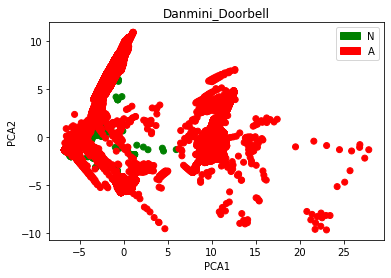

processing 2.benign.csv rows = 13113
processing 2.gafgyt.combo.csv rows = 53012
processing 2.gafgyt.junk.csv rows = 30312
processing 2.gafgyt.scan.csv rows = 27494
processing 2.gafgyt.tcp.csv rows = 95021
processing 2.gafgyt.udp.csv rows = 104791
processing 2.mirai.ack.csv rows = 113285
processing 2.mirai.scan.csv rows = 43192
processing 2.mirai.syn.csv rows = 116807
processing 2.mirai.udp.csv rows = 151481
processing 2.mirai.udpplain.csv rows = 87368


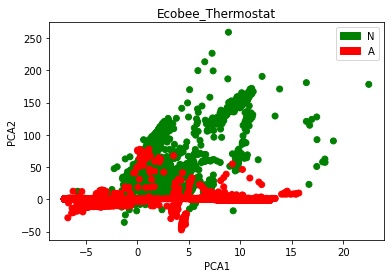

processing 3.benign.csv rows = 39100
processing 3.gafgyt.combo.csv rows = 53014
processing 3.gafgyt.junk.csv rows = 29797
processing 3.gafgyt.scan.csv rows = 28120
processing 3.gafgyt.tcp.csv rows = 101536
processing 3.gafgyt.udp.csv rows = 103933


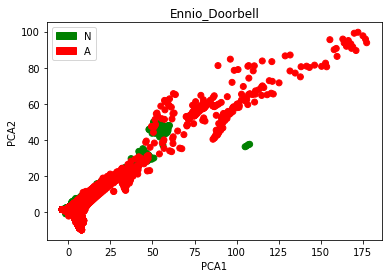

processing 4.benign.csv rows = 175240
processing 4.gafgyt.combo.csv rows = 58152
processing 4.gafgyt.junk.csv rows = 28349
processing 4.gafgyt.scan.csv rows = 27859
processing 4.gafgyt.tcp.csv rows = 92581
processing 4.gafgyt.udp.csv rows = 105782
processing 4.mirai.ack.csv rows = 91123
processing 4.mirai.scan.csv rows = 103621
processing 4.mirai.syn.csv rows = 118128
processing 4.mirai.udp.csv rows = 217034
processing 4.mirai.udpplain.csv rows = 80808


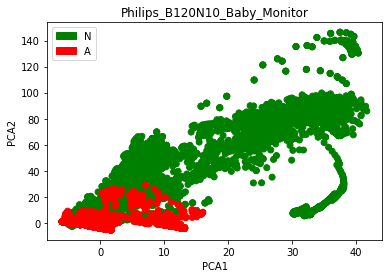

processing 5.benign.csv rows = 62154
processing 5.gafgyt.combo.csv rows = 61380
processing 5.gafgyt.junk.csv rows = 30898
processing 5.gafgyt.scan.csv rows = 29297
processing 5.gafgyt.tcp.csv rows = 104510
processing 5.gafgyt.udp.csv rows = 104011
processing 5.mirai.ack.csv rows = 60554
processing 5.mirai.scan.csv rows = 96781
processing 5.mirai.syn.csv rows = 65746
processing 5.mirai.udp.csv rows = 156248
processing 5.mirai.udpplain.csv rows = 56681


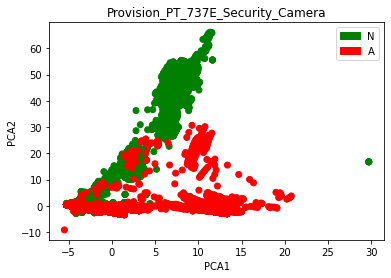

processing 6.benign.csv rows = 98514
processing 6.gafgyt.combo.csv rows = 57530
processing 6.gafgyt.junk.csv rows = 29068
processing 6.gafgyt.scan.csv rows = 28397
processing 6.gafgyt.tcp.csv rows = 89387
processing 6.gafgyt.udp.csv rows = 104658
processing 6.mirai.ack.csv rows = 57997
processing 6.mirai.scan.csv rows = 97096
processing 6.mirai.syn.csv rows = 61851
processing 6.mirai.udp.csv rows = 158608
processing 6.mirai.udpplain.csv rows = 53785


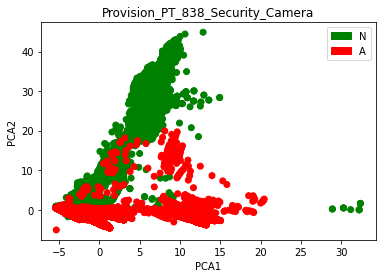

processing 7.benign.csv rows = 52150
processing 7.gafgyt.combo.csv rows = 58669
processing 7.gafgyt.junk.csv rows = 28305
processing 7.gafgyt.scan.csv rows = 27698
processing 7.gafgyt.tcp.csv rows = 97783
processing 7.gafgyt.udp.csv rows = 110617


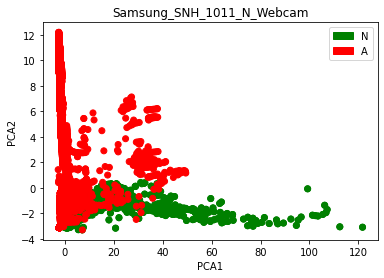

processing 8.benign.csv rows = 46585
processing 8.gafgyt.combo.csv rows = 54283
processing 8.gafgyt.junk.csv rows = 28579
processing 8.gafgyt.scan.csv rows = 27825
processing 8.gafgyt.tcp.csv rows = 88816
processing 8.gafgyt.udp.csv rows = 103720
processing 8.mirai.ack.csv rows = 111480
processing 8.mirai.scan.csv rows = 45930
processing 8.mirai.syn.csv rows = 125715
processing 8.mirai.udp.csv rows = 151879
processing 8.mirai.udpplain.csv rows = 78244


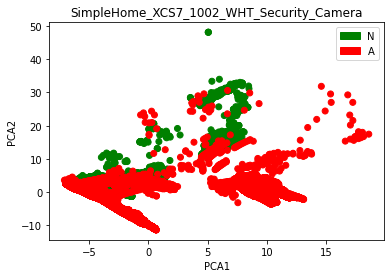

processing 9.benign.csv rows = 19528
processing 9.gafgyt.combo.csv rows = 59398
processing 9.gafgyt.junk.csv rows = 27413
processing 9.gafgyt.scan.csv rows = 28572
processing 9.gafgyt.tcp.csv rows = 98075
processing 9.gafgyt.udp.csv rows = 102980
processing 9.mirai.ack.csv rows = 107187
processing 9.mirai.scan.csv rows = 43674
processing 9.mirai.syn.csv rows = 122479
processing 9.mirai.udp.csv rows = 157084
processing 9.mirai.udpplain.csv rows = 84436


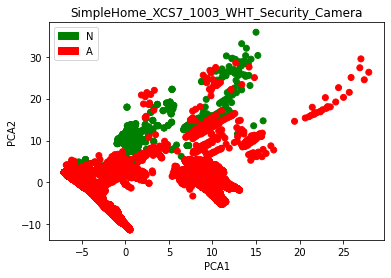

In [5]:
plot_scatter_nbaiot_devices(False) # 2D Scatter Plots